# nuvT(neutrino interaction time) reconstruction

The goal of this project is to develop a neural network that uses the scintillation light produced in SBND, a liquid argon TPC exposed to a neutrino beam at Fermilab. The neural network uses the number of photoelectrons observed in each of the channels in an event as input. The output estimate is the temporal coordinate of the neutrino interaction.

This program employs a CNN composed of convolutional layers (along with MaxPooling) followed by a fully connected network. The input consists of "images" with the spatial correlation of the detector map, forming four layers (separating visible and ultraviolet detectors; and both volumes).

## Import libraries

In [2]:
import uproot
import awkward as ak
import json

import statistics as st
import collections
from random import randint
#import visualkeras
from sklearn.metrics import mean_squared_error

#typical libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#tensorflow module
import tensorflow as tf
from tensorflow.keras import layers # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.callbacks import ModelCheckpoint # type: ignore


2024-08-30 15:39:40.224861: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-30 15:39:40.231363: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-30 15:39:40.248452: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-30 15:39:40.275392: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-30 15:39:40.283067: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-30 15:39:40.304607: I tensorflow/core/platform/cpu_feature_gu

## Data analysis and preparation

The data corresponds to the Monte Carlo simulation of the SBND experiment. It was obtained by simulating the creation of neutrinos in the beam and their subsequent interaction in SBND, as well as the simulation of the detector's response to the particles resulting from the interaction of the neutrinos.

In [3]:
file_path = '../prueba_opana_tree.root'
file = uproot.open(file_path)

In [4]:
optree = file['opanatree']['OpAnaTree'] # Tree con número de fotoelectrones
optree.keys()

['eventID',
 'runID',
 'subrunID',
 'nuvX',
 'nuvY',
 'nuvZ',
 'nuvT',
 'nuvE',
 'stepX',
 'stepY',
 'stepZ',
 'stepT',
 'dE',
 'energydep',
 'energydepX',
 'energydepY',
 'energydepZ',
 'E',
 'StartPx',
 'StartPy',
 'StartPz',
 'EndPx',
 'EndPy',
 'EndPz',
 'process',
 'trackID',
 'motherID',
 'PDGcode',
 'InTimeCosmics',
 'InTimeCosmicsTime',
 'dEtpc',
 'dEpromx',
 'dEpromy',
 'dEpromz',
 'dEspreadx',
 'dEspready',
 'dEspreadz',
 'dElowedges',
 'dEmaxedges',
 'SimPhotonsperOpChVUV',
 'SimPhotonsperOpChVIS',
 'NPhotons',
 'NPhotonsPMTCo',
 'NPhotonsPMTUnco',
 'NPhotonsPMTCoVUV',
 'NPhotonsXARAPUCAVUV',
 'NPhotonsXARAPUCAVIS',
 'SimPhotonsLiteVUV',
 'SimPhotonsLiteVIS',
 'nophits',
 'ophit_opch',
 'ophit_peakT',
 'ophit_startT',
 'ophit_riseT',
 'ophit_width',
 'ophit_area',
 'ophit_amplitude',
 'ophit_pe',
 'nopflash',
 'flash_id',
 'flash_time',
 'flash_total_pe',
 'flash_pe_v',
 'flash_tpc',
 'flash_y',
 'flash_yerr',
 'flash_z',
 'flash_zerr',
 'flash_x',
 'flash_xerr',
 'flash_oph

In [5]:
# Carga asociada a cada evento, hit, canal y tiempo
hit_PE = optree['flash_ophit_pe'].array()
print(hit_PE)
print(len(hit_PE))
# Canal asociado a cada evento, hit, carga recogida y tiempo
hit_ch = optree['flash_ophit_ch'].array()
print(hit_ch)
print(len(hit_ch))

# Tiempo asociado a cada evento, hit, canal y carga recogida
hit_t = optree['flash_ophit_time'].array()
print(hit_t)
print(len(hit_t))

[[[2.68, 3.42, 2.56, 0.449, ..., 6.86e+03, 7.33e+03, 7.63e+03], ...], ...]
50
[[[246, 90, 70, 92, 138, 60, 64, 10, ..., 60, 8, 6, 70, 68, 64, 10], ...], ...]
50
[[[390, 390, 390, 390, 390, 390, ..., 382, 382, 382, 382, 382, 382], ...], ...]
50


In [6]:
hit_nuvT = ak.to_list(optree['nuvT'].array())
print(hit_nuvT)
print(len(hit_nuvT))

[[1555.602621156906], [1665.678496427165], [1038.3146308856944], [1771.1725396696438], [1397.4248730783997, 917.9466411712071], [1164.0717902641388], [1876.6514949709085], [1095.1745694421115, 580.784580648595], [738.8165027957493], [1742.729408030566, 1427.026599787747], [1075.1769010465855], [1363.3600647005178], [975.4657423594067], [513.225096667715], [1826.5596898138754], [1785.0914560657711], [1375.532730563527], [400.9962554648186, 1738.937861161509], [1336.7374989934883], [1038.792941331223], [1020.7707048158934], [1256.9839807286019, 472.7169074796713], [1092.1407165370756], [1147.4585210598962], [1234.4288305890493], [1389.9213118381467], [1014.5229804991807], [1659.9725640554086], [1349.9484207611113], [623.6054156275502], [382.6051719914009], [738.9172684617547], [1856.863620489794], [1481.5265884880569], [1018.071241187062], [1086.7287275832316], [743.0944576410993], [1067.3821600129957], [521.6839643281745], [1326.4269140859005], [768.3150505877466], [850.2105569719832], 

In [7]:
n_eventos = len(hit_ch)
n_canales = 312

# Creamos la matriz donde guardar el número de fotoelectrones recogidos en cada canal y por cada evento
fotoelectrones = np.zeros((n_eventos,n_canales))
tiempos = np.zeros((n_eventos,n_canales))

for i in range(n_eventos):
  max_carga_indice = np.zeros(n_canales)
  for j in range(len(hit_PE[i])):
    for k, l, t in zip(hit_PE[i][j], hit_ch[i][j], hit_t[i][j]):
      fotoelectrones[i][l] += k
      tiempos[i][l] += k*t # Ponderamos usando como pesos las cargas

KeyboardInterrupt: 

In [ ]:
# Se normaliza con la suma total de los pesos, que es la matriz de fotoelectrones
for i in range(n_eventos):
  for j in range(n_canales):
    if fotoelectrones[i][j] != 0:
      tiempos[i][j] /= fotoelectrones[i][j]
    else:
      tiempos[i][j] = 0

### Import channel data

Descargamos el fichero JSON con la lista e información de canales.

In [20]:
PDSMap = file['opanatree']['PDSMapTree']
PDSMap.keys()

['OpDetID', 'OpDetX', 'OpDetY', 'OpDetZ', 'OpDetType']

In [24]:
ID = PDSMap['OpDetID'].array()
X = PDSMap['OpDetX'].array()
Y = PDSMap['OpDetY'].array()
Z = PDSMap['OpDetZ'].array()
Type = PDSMap['OpDetType'].array()


data_dict = {id_val: (x_val, y_val, z_val,type_val) for id_val, x_val, y_val, z_val, type_val in zip(ID[0], X[0], Y[0], Z[0],Type[0])}
print(data_dict)
# Function to determine if the ID is even
def is_even_id(id_val):
    return id_val % 2 == 0

# Separate data into even and odd dictionaries
even_data_dict = {id_val: data for id_val, data in data_dict.items() if is_even_id(id_val)}
odd_data_dict = {id_val: data for id_val, data in data_dict.items() if not is_even_id(id_val)}


{0: (-213.75, -135.0, 20.254225000000027, 3), 1: (213.74999999999997, -135.0, 20.254225000000027, 3), 2: (-213.75, 0.0, 20.254225000000027, 3), 3: (213.74999999999997, 0.0, 20.254225000000027, 3), 4: (-213.75, 135.0, 20.254225000000027, 3), 5: (213.74999999999997, 135.0, 20.254225000000027, 3), 6: (-213.4, -175.0, 27.874225000000024, 0), 7: (213.39999999999998, -175.0, 27.874225000000024, 0), 8: (-213.4, -95.0, 27.874225000000024, 0), 9: (213.39999999999998, -95.0, 27.874225000000024, 0), 10: (-213.4, -40.0, 27.874225000000024, 0), 11: (213.39999999999998, -40.0, 27.874225000000024, 0), 12: (-213.4, 40.0, 27.874225000000024, 0), 13: (213.39999999999998, 40.0, 27.874225000000024, 0), 14: (-213.4, 95.0, 27.874225000000024, 0), 15: (213.39999999999998, 95.0, 27.874225000000024, 0), 16: (-213.4, 175.0, 27.874225000000024, 0), 17: (213.39999999999998, 175.0, 27.874225000000024, 0), 18: (-213.75, -135.0, 35.49422500000002, 2), 19: (213.75, -135.0, 35.49422500000002, 2), 20: (-213.75, 0.0, 35

In [35]:
import plotly.graph_objs as go
import plotly.express as px

# Your data dictionary
data = data_dict

# Extract coordinates
x = [coord[0] for coord in data.values()]
y = [coord[1] for coord in data.values()]
z = [coord[2] for coord in data.values()]
color = [coord[3] for coord in data.values()]
ids = [key for key in data_dict.keys()]
# Create a scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=z,
    z=y,
    mode='markers',
    marker=dict(
        size=5,
        color=color,  # Set color based on the fourth dimension
        #colorscale=color_scale,  # Define color scale
        colorbar=dict(title='Color Scale')  # Add colorbar to show color scale
    ),
    text=ids,  # Display point IDs on hover
    #hoverinfo='text'  # Show only the text (IDs) on hover
)])

# Set labels
fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Z',
    zaxis_title='Y'
))

fig.show()


In [31]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots


# Extract coordinates, color values, and IDs for even and odd 2D plots
hor_even = [coord[2] for coord in even_data_dict.values()]
ver_even = [coord[1] for coord in even_data_dict.values()]
color_even = [coord[3] for coord in even_data_dict.values()]
ids_even = [key for key in even_data_dict.keys()]

hor_odd = [coord[2] for coord in odd_data_dict.values()]
ver_odd = [coord[1] for coord in odd_data_dict.values()]
color_odd = [coord[3] for coord in odd_data_dict.values()]
ids_odd = [key for key in odd_data_dict.keys()]

# Define a custom color map with distinct colors
distinct_colors = ['rgb(255,0,0)', 'rgb(0,255,0)', 'rgb(0,0,255)', 'rgb(255,0,255)']
color_map = {i: distinct_colors[i % len(distinct_colors)] for i in range(len(set(color_even)))}
colored_text_odd = [f'<span style="color: {color_map.get(col, "black")}">{id_}</span>' for id_, col in zip(ids_odd, color_odd)]
colored_text_even = [f'<span style="color: {color_map.get(col, "black")}">{id_}</span>' for id_, col in zip(ids_even, color_even)]

# Create subplot grid
fig = make_subplots(rows=2, cols=1,subplot_titles=('Even IDs', 'Odd IDs'), vertical_spacing=0.15)

# Add 2D scatter plot for even IDs
fig.add_trace(go.Scatter(
    x=hor_even,
    y=ver_even,
    mode='text',  # Use both markers and text
    text=colored_text_even,  # Display colored IDs as text labels
    textposition='top center',  # Position text labels
    marker=dict(
        size=10,  # Marker size
        color=color_even,  # Set color based on the fourth dimension
        colorscale='Jet',  # Define color scale
        colorbar=dict(title='Color Scale')  # Add colorbar to show color scale
    ),
    hoverinfo='text',  # Show text on hover
), row=1, col=1)

# Add 2D scatter plot for odd IDs
fig.add_trace(go.Scatter(
    x=hor_odd,
    y=ver_odd,
    mode='text',  # Use both markers and text
    text=colored_text_odd,  # Display colored IDs as text labels
    textposition='top center',  # Position text labels
    marker=dict(
        size=10,  # Marker size
        color=color_odd,  # Set color based on the fourth dimension
        colorscale='Jet',  # Define color scale
        colorbar=dict(title='Color Scale')  # Add colorbar to show color scale
    ),
    hoverinfo='text',  # Show text on hover
), row=2, col=1)

legend_labels = ['0: CoatedPMT (VIS and VUV)', '1: UncoatedPMT (only VIS)', '2: VUV XARAPUCA', '3: VIS XARAPUCA']
for i, label in enumerate(legend_labels):
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        marker=dict(
            size=10,
            color=distinct_colors[i],  # Color for each label
            showscale=False
        ),
        name=label
    ))

# Update layout
fig.update_layout(
    title='2D Detector Planes',
    width=1200,  # Set figure width
    height=800,  # Set figure height
    xaxis=dict(
        title='Z',
    ),
    yaxis=dict(
        title='Y',
    ),
    xaxis2=dict(
        title='Z',
    ),
    yaxis2=dict(
        title='Y',
    ),
      margin=dict(l=10, r=10, t=50, b=10),
    
)

# Show the plot
fig.show()

Generamos el mapa de detectores donde se ve la distribución espacial de estos.

In [ ]:
vis_map = np.array(([-2,-2,24,-2,-2,-2,-2,-2,102,-2,-2,-2,-2,-2,180,-2,-2,-2,-2,-2,258,-2,-2,-2],
                           [0,-2,-2,-2,54,-2,78,-2,-2,-2,132,-2,156,-2,-2,-2,210,-2,234,-2,-2,-2,288,-2],
                           [-2,-2,26,-2,-2,-2,-2,-2,104,-2,-2,-2,-2,-2,182,-2,-2,-2,-2,-2,260,-2,-2,-2],
                           [-2,-2,28,-2,-2,-2,-2,-2,106,-2,-2,-2,-2,-2,184,-2,-2,-2,-2,-2,262,-2,-2,-2],
                           [2,-2,-2,-2,56,-2,80,-2,-2,-2,134,-2,158,-2,-2,-2,212,-2,236,-2,-2,-2,290,-2],
                           [-2,-2,30,-2,-2,-2,-2,-2,108,-2,-2,-2,-2,-2,186,-2,-2,-2,-2,-2,264,-2,-2,-2],
                           [-2,-2,32,-2,-2,-2,-2,-2,110,-2,-2,-2,-2,-2,188,-2,-2,-2,-2,-2,266,-2,-2,-2],
                           [4,-2,-2,-2,58,-2,82,-2,-2,-2,136,-2,160,-2,-2,-2,214,-2,238,-2,-2,-2,292,-2],
                           [-2,-2,34,-2,-2,-2,-2,-2,112,-2,-2,-2,-2,-2,190,-2,-2,-2,-2,-2,268,-2,-2,-2]))

vuv_map = np.array(([-2,-2,-2,42,-2,-2,-2,-2,-2,120,-2,-2,-2,-2,-2,198,-2,-2,-2,-2,-2,276,-2,-2],
                           [-2,18,-2,-2,-2,72,-2,96,-2,-2,-2,150,-2,174,-2,-2,-2,228,-2,252,-2,-2,-2,306],
                           [-2,-2,-2,44,-2,-2,-2,-2,-2,122,-2,-2,-2,-2,-2,200,-2,-2,-2,-2,-2,278,-2,-2],
                           [-2,-2,-2,46,-2,-2,-2,-2,-2,124,-2,-2,-2,-2,-2,202,-2,-2,-2,-2,-2,280,-2,-2],
                           [-2,10,-2,-2,-2,74,-2,98,-2,-2,-2,152,-2,176,-2,-2,-2,230,-2,254,-2,-2,-2,308],
                           [-2,-2,-2,48,-2,-2,-2,-2,-2,126,-2,-2,-2,-2,-2,204,-2,-2,-2,-2,-2,282,-2,-2],
                           [-2,-2,-2,50,-2,-2,-2,-2,-2,128,-2,-2,-2,-2,-2,206,-2,-2,-2,-2,-2,284,-2,-2],
                           [-2,22,-2,-2,-2,76,-2,100,-2,-2,-2,154,-2,178,-2,-2,-2,232,-2,256,-2,-2,-2,310],
                           [-2,-2,-2,52,-2,-2,-2,-2,-2,130,-2,-2,-2,-2,-2,208,-2,-2,-2,-2,-2,286,-2,-2]))



vis_map = np.row_stack((vis_map,vis_map+1))
vuv_map = np.row_stack((vuv_map,vuv_map+1))


In [ ]:
ch_y = 12
ch_z = 9

# Creamos la matriz con distribución espacial
fotoelectrones_vis_map = np.zeros((n_eventos,ch_z*2,ch_y*2))
fotoelectrones_vuv_map = np.zeros((n_eventos,ch_z*2,ch_y*2))

tiempos_vis_map = np.zeros((n_eventos,ch_z*2,ch_y*2))
tiempos_vuv_map = np.zeros((n_eventos,ch_z*2,ch_y*2))

for i in range(n_eventos):
  for j in range(ch_z*2):
    for k in range(ch_y*2):
      if vis_map[j][k] >= 0:
        fotoelectrones_vis_map[i][j][k] = fotoelectrones[i][vis_map[j][k]]
        tiempos_vis_map[i][j][k] = tiempos[i][vis_map[j][k]]
      if vuv_map[j][k] >= 0:
        fotoelectrones_vuv_map[i][j][k] = fotoelectrones[i][vuv_map[j][k]]
        tiempos_vuv_map[i][j][k] = tiempos[i][vuv_map[j][k]]

# Dividimos los sensores de diferente radiación en dos capas distintas y también por volúmenes
fotoelectrones_vis_map = np.hsplit(fotoelectrones_vis_map, 2)/np.max(fotoelectrones)
fotoelectrones_vuv_map = np.hsplit(fotoelectrones_vuv_map, 2)/np.max(fotoelectrones)

tiempos_vis_map = np.hsplit(tiempos_vis_map, 2)/np.max(tiempos)
tiempos_vuv_map = np.hsplit(tiempos_vuv_map, 2)/np.max(tiempos)

image = np.zeros((np.shape(fotoelectrones_vis_map[0])[0],np.shape(fotoelectrones_vis_map[0])[1],np.shape(fotoelectrones_vis_map[0])[2],8))

image[:,:,:,0] = fotoelectrones_vis_map[0]
image[:,:,:,1] = fotoelectrones_vis_map[1]
image[:,:,:,2] = fotoelectrones_vuv_map[0]
image[:,:,:,3] = fotoelectrones_vuv_map[1]

image[:,:,:,4] = tiempos_vis_map[0]
image[:,:,:,5] = tiempos_vis_map[1]
image[:,:,:,6] = tiempos_vuv_map[0]
image[:,:,:,7] = tiempos_vuv_map[1]


print('Number of events, image height, width, layers:', np.shape(image))

Number of events, image height, width, layers: (9800, 9, 24, 8)



# Visualización de los datos



C1: Visible/Volumen -  ||  C2: Visible/Volumen +  ||  C3: Ultravioleta/Volumen -  ||  C4: Ultravioleta/Volumen +  ||  T1: Visible/Volumen -  ||  T2: Visible/Volumen +  ||  T3: Ultravioleta/Volumen -  ||  T4: Ultravioleta/Volumen +


[]

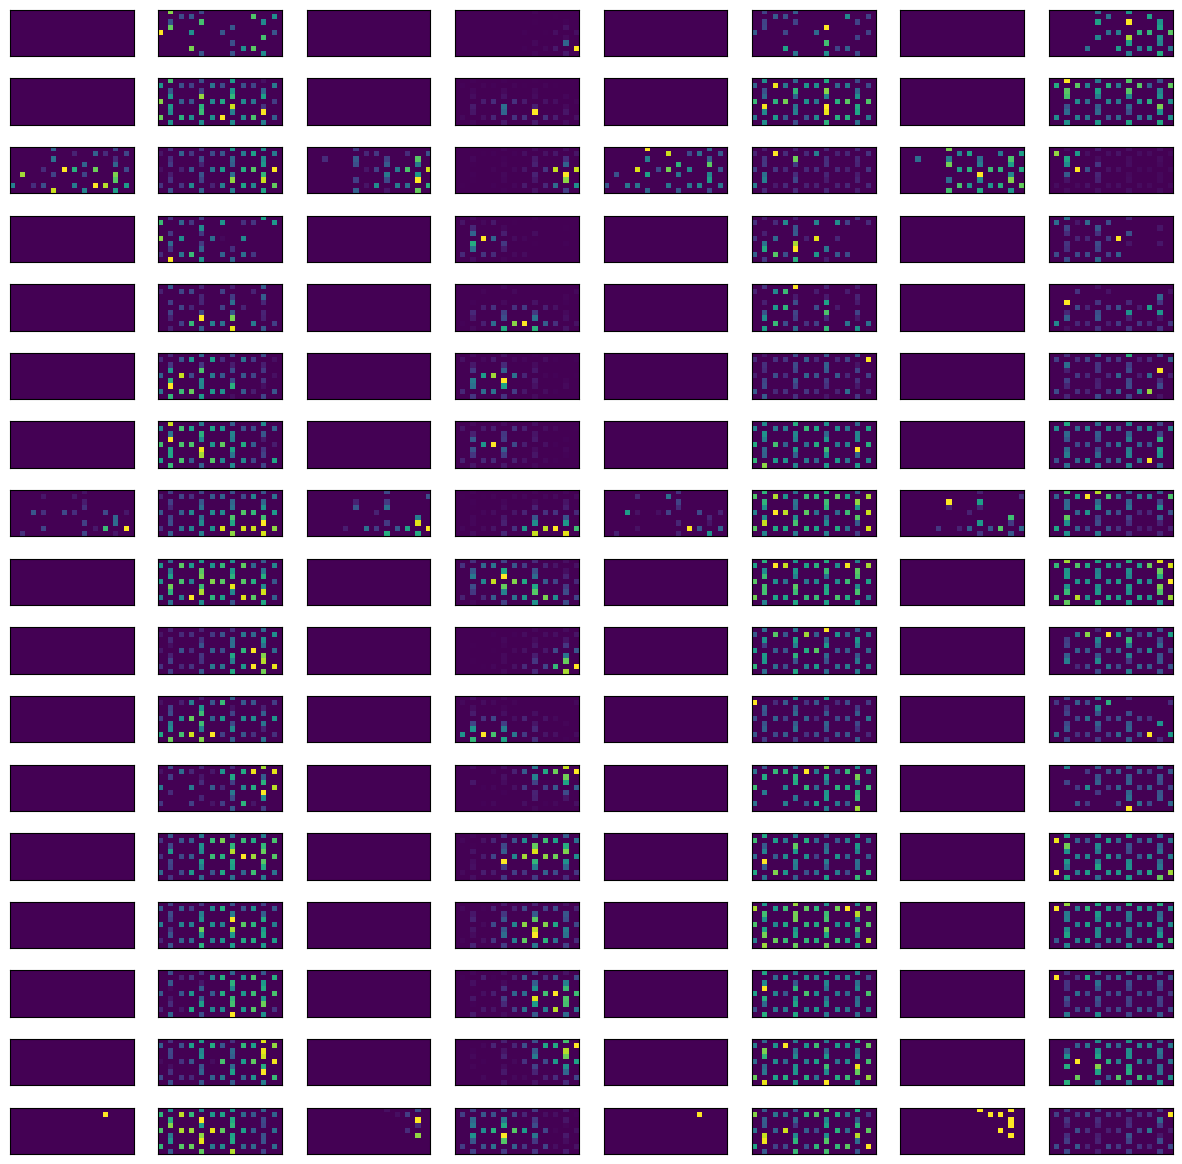

In [ ]:
event_index = np.array([30,0,31,27,68,56,61,32,25,92,54,38,18,16,12,37,8])

print('C1: Visible/Volumen -  ||  C2: Visible/Volumen +  ||  C3: Ultravioleta/Volumen -  ||  C4: Ultravioleta/Volumen +  ||  T1: Visible/Volumen -  ||  T2: Visible/Volumen +  ||  T3: Ultravioleta/Volumen -  ||  T4: Ultravioleta/Volumen +')

fig, axs = plt.subplots(17, 8, figsize=(15, 15))

for i in range(17):
  for j in range(8):
    axs[i,j].imshow(image[event_index[i],:,:,j])

plt.setp(axs, xticks=[], yticks=[])



# Reconstrucción de las coordenadas de forma individual

## Separación de los conjuntos de entrenamiento y prueba

Verificamos la dimensionalidad

In [ ]:
assert np.shape(image)[0] == np.shape(Hit_nuvT)[0]

Separamos el 60% de los datos para formar el conjunto de prueba

In [ ]:
test_size = int(np.floor(0.60*np.shape(Hit_nuvT)[0]) )
print(test_size)

5880


In [ ]:
train_nuvTxarap, test_nuvTxarap = image[:-test_size], image[-test_size:]

train_nuvT, test_nuvT = Hit_nuvT[:-test_size], Hit_nuvT[-test_size:]

print(train_nuvTxarap.shape,test_nuvTxarap.shape)
print(len(train_nuvT),len(test_nuvT))


(3920, 9, 24, 8) (5880, 9, 24, 8)
3920 5880


In [ ]:
input = layers.Input(shape=(train_nuvTxarap.shape[1], train_nuvTxarap.shape[2], train_nuvTxarap.shape[3]))

model = layers.BatchNormalization()(input)

model = layers.Conv2D(128, (3, 3), padding='same')(model)
model = layers.LeakyReLU(alpha=0.1)(model)
model = layers.MaxPooling2D((2, 2),padding='same')(model)
model = layers.Dropout(0.3)(model)

model = layers.Conv2D(256, (3, 3), padding='same')(model)
model = layers.LeakyReLU(alpha=0.1)(model)
model = layers.MaxPooling2D(pool_size=(2, 2),padding='same')(model)
model = layers.Dropout(0.3)(model)

model = layers.Conv2D(512, (3, 3), padding='same')(model)
model = layers.LeakyReLU(alpha=0.1)(model)
model = layers.MaxPooling2D(pool_size=(2, 2),padding='same')(model)
model = layers.Dropout(0.4)(model)

model = layers.Flatten()(model)

model = layers.Dense(2048, activation='relu')(model)
model = layers.Dropout(0.2)(model)

model = layers.Dense(512, activation='relu')(model)
model = layers.Dense(128, activation='relu')(model)

output = layers.Dense(1, activation='linear')(model)

# Entrenando el modelo en la coordenada t

Se compila el modelo, incluyendo la elección del optimizador y del error que se minimizará durante el entrenamiento.

In [ ]:
# Creamos los modelos:
model_nuvT = Model(input, output)

In [ ]:
model_nuvT.summary()
model_nuvT.compile(loss='mse', optimizer='adam', metrics='mse')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9, 24, 8)]        0         
                                                                 
 batch_normalization (Batch  (None, 9, 24, 8)          32        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 9, 24, 128)        9344      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 9, 24, 128)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 5, 12, 128)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 5, 12, 128)        0     

In [ ]:
best_weights_file = "/tmp/weights_nuvT.hdf5"
checkpoint = ModelCheckpoint(best_weights_file, monitor='mse', verbose=0, save_best_only=True, mode='min')

# probar a modificar el batch_size (hacerlo más grande)
callbacks = [checkpoint]
history_t = model_nuvT.fit(train_nuvTxarap, train_nuvT,
                        epochs=30, batch_size=32, callbacks=callbacks,
                        validation_data=(test_nuvTxarap, test_nuvT),
                        verbose=2)

Epoch 1/30
123/123 - 72s - loss: 105919.2266 - mse: 105919.2266 - val_loss: 158855.7031 - val_mse: 158855.7031 - 72s/epoch - 586ms/step
Epoch 2/30
123/123 - 71s - loss: 95287.2266 - mse: 95287.2266 - val_loss: 113705.5156 - val_mse: 113705.5156 - 71s/epoch - 577ms/step
Epoch 3/30
123/123 - 60s - loss: 90535.7344 - mse: 90535.7344 - val_loss: 74411.9531 - val_mse: 74411.9531 - 60s/epoch - 487ms/step
Epoch 4/30
123/123 - 70s - loss: 77525.3438 - mse: 77525.3438 - val_loss: 95859.3984 - val_mse: 95859.3984 - 70s/epoch - 572ms/step
Epoch 5/30
123/123 - 72s - loss: 66562.6797 - mse: 66562.6797 - val_loss: 76123.9844 - val_mse: 76123.9844 - 72s/epoch - 583ms/step
Epoch 6/30
123/123 - 71s - loss: 63752.8164 - mse: 63752.8164 - val_loss: 70652.9062 - val_mse: 70652.9062 - 71s/epoch - 578ms/step
Epoch 7/30
123/123 - 71s - loss: 62107.3320 - mse: 62107.3320 - val_loss: 62936.4883 - val_mse: 62936.4883 - 71s/epoch - 574ms/step
Epoch 8/30
123/123 - 77s - loss: 79354.9141 - mse: 79354.9141 - val_lo

In [ ]:
best_weights_file = "/tmp/weights_nuvT.hdf5"
model_nuvT.load_weights(best_weights_file)
nuvT_pred = model_nuvT.predict(test_nuvTxarap)

245/245 [==============================] - 6s 26ms/step


# Visualización de resultados

Se calcula el error cuadrático medio del pronóstico.

In [ ]:
testScoreECM_nuvT = mean_squared_error(test_nuvT, nuvT_pred)
print('RECM_nuvT: %.4f' % np.sqrt((testScoreECM_nuvT)))

RECM_nuvT: 186.4238


En la siguiente gráfica se visualiza la evolución del error para el conjunto de entrenamiento y test en función de las épocas.

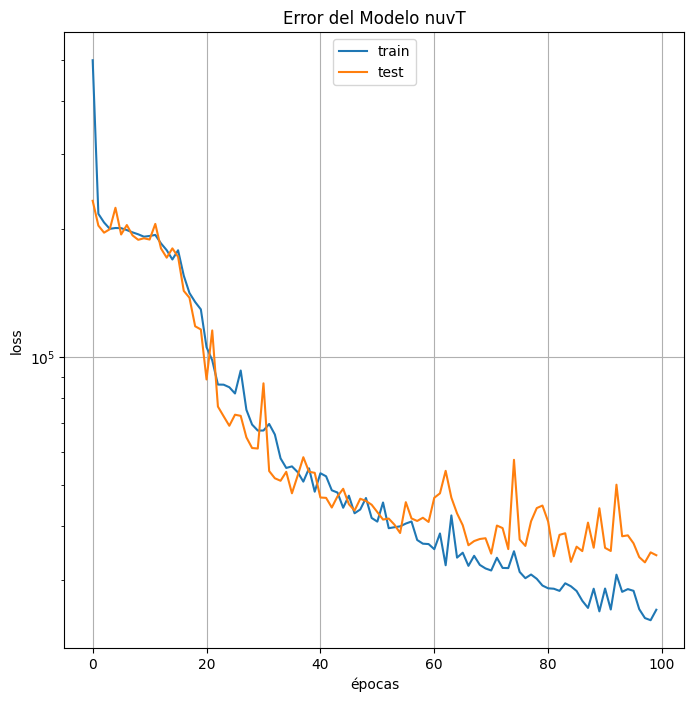

In [ ]:
plt.figure(1, figsize=(8,8))
plt.plot(history_t.history['mse'])
plt.plot(history_t.history['val_mse'])

plt.yscale("log")
plt.title('Error del Modelo nuvT')
plt.ylabel('loss')
plt.xlabel('épocas')
plt.grid()
plt.legend(['train', 'test'], loc='upper center')
plt.show()

Es importante verificar hasta donde sea posible la distribución de errores. En la siguiente gráfica se muestra el pronóstico contra los datos reales.

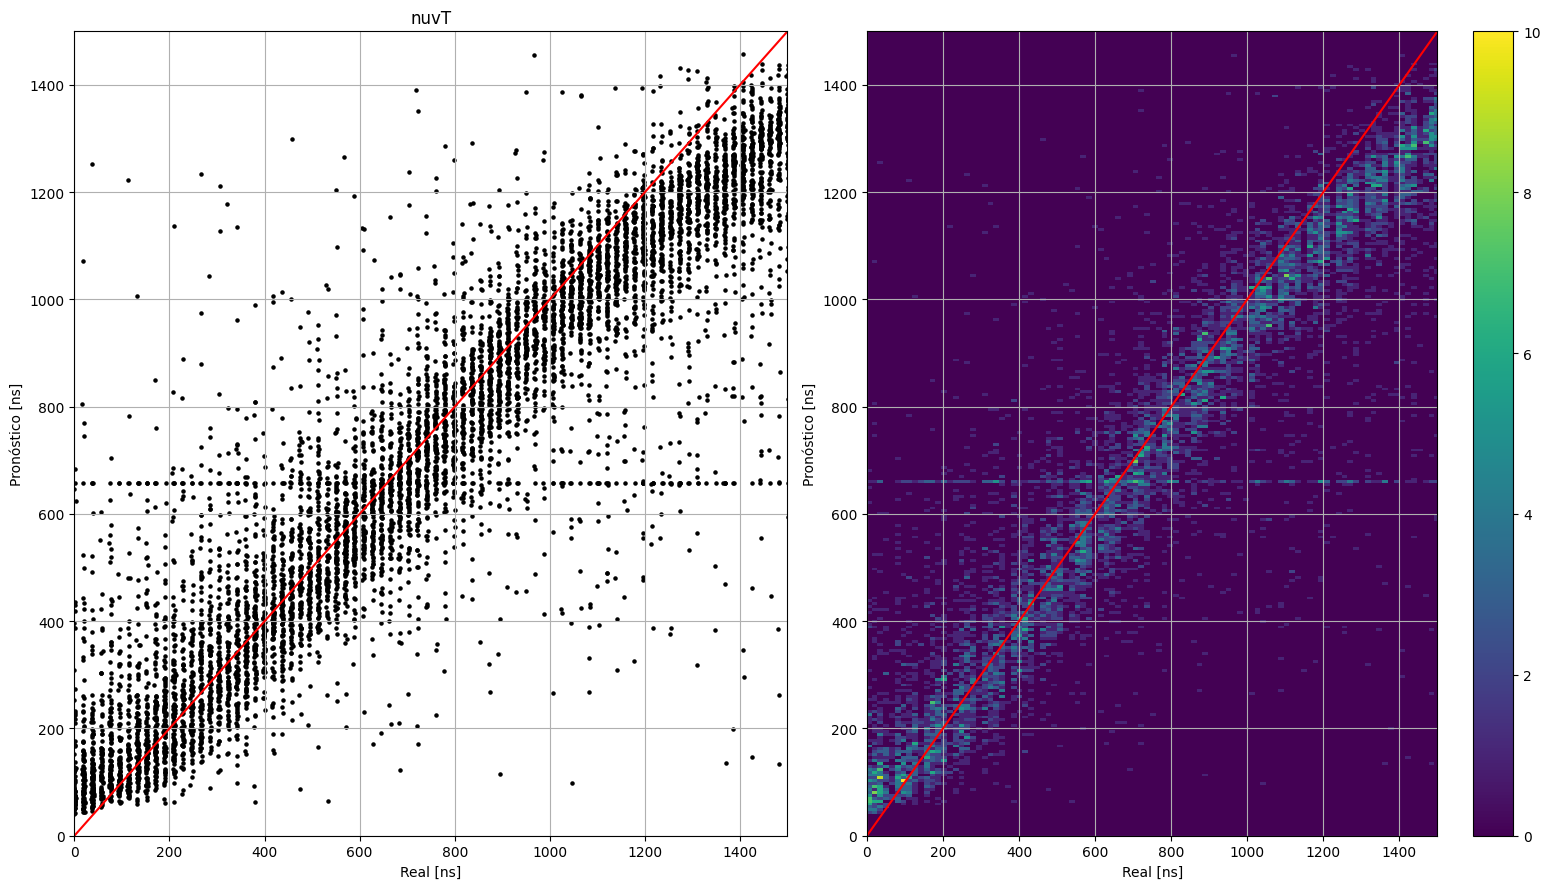

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(16,9))

axs[0].scatter(test_nuvT, nuvT_pred, color="black",s=5)
axs[0].grid()

axs[0].plot([0,1500],[0,1500],color="r")
axs[0].title.set_text('nuvT')
axs[0].set_xlim([0,1500])
axs[0].set_ylim([0,1500])
axs[0].set_ylabel('Pronóstico [ns]')
axs[0].set_xlabel('Real [ns]')


im1 = axs[1].hist2d(test_nuvT, nuvT_pred.flatten(), bins=(100, 300), cmap='viridis',cmax=30)
fig.colorbar(im1[3], ax=axs[1])
axs[1].grid()

axs[1].plot([0,1500],[0,1500],color="r")
axs[1].set_xlim([0,1500])
axs[1].set_ylim([0,1500])
axs[1].set_ylabel('Pronóstico [ns]')
axs[1].set_xlabel('Real [ns]')
axs[1].set_facecolor('#440154')

fig.tight_layout()

# plt.savefig('/tmp/CNNx2+4T+N_Recta_I.png', dpi=300)

Finalmente se realizan ajustes gaussianos al error entre pronóstico y datos reales para comprobar la calidad de los resultados.

------------------
Media nuvT = -33.540239781983615
Sigma nuvT = 105.78289056080031
------------------


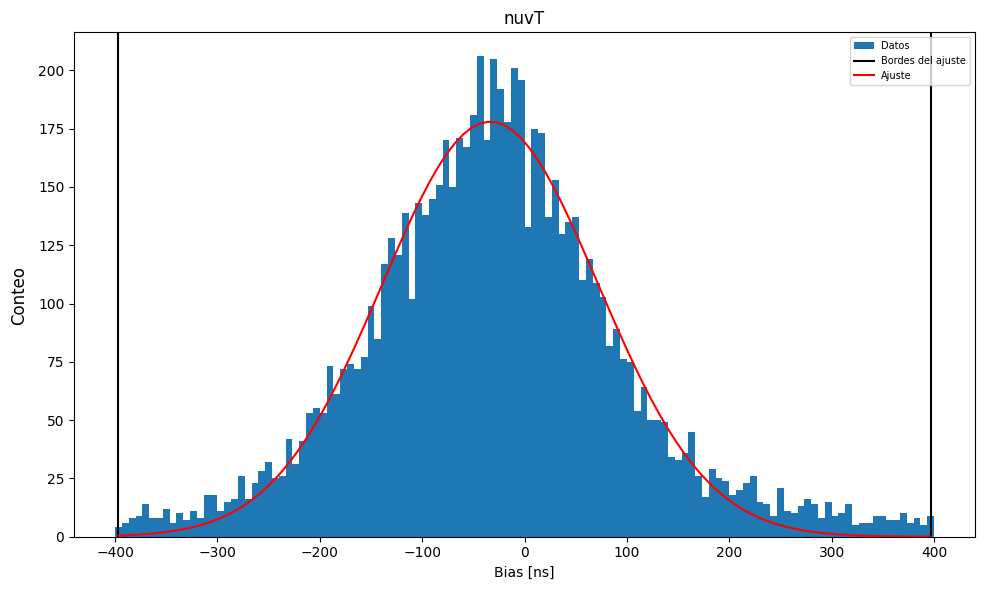

In [ ]:
# Ajuste gaussiano de las diferencias entre el pronóstico y el valor real

from scipy.optimize import curve_fit

# Define the Gaussian function
def func(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

# Variables de los histogramas
diff_nuvT = nuvT_pred.flatten()-test_nuvT

fig, axs = plt.subplots(figsize=(10,6))

# Valores de X
axs.title.set_text('nuvT')
counts_nuvT, bins_nuvT, patches_nuvT = axs.hist(diff_nuvT,120, range=[-400,400], label='Datos')

step_nuvT = (bins_nuvT[1]-bins_nuvT[0])/2
bin_centers_nuvT = bins_nuvT[:-1]+step_nuvT

ini_nuvT = 0
fin_nuvT = 119
axs.axvline(x = bin_centers_nuvT[ini_nuvT], color = 'k', label='Bordes del ajuste')
axs.axvline(x = bin_centers_nuvT[fin_nuvT], color = 'k')

popt_nuvT, pcov_nuvT = curve_fit(func, bin_centers_nuvT[ini_nuvT:fin_nuvT+1], counts_nuvT[ini_nuvT:fin_nuvT+1])


ym_nuvT = func(np.linspace(bin_centers_nuvT[ini_nuvT], bin_centers_nuvT[fin_nuvT],100), popt_nuvT[0], popt_nuvT[1], popt_nuvT[2])
axs.plot(np.linspace(bin_centers_nuvT[ini_nuvT], bin_centers_nuvT[fin_nuvT],100), ym_nuvT, c='r', label='Ajuste')
axs.set_xlabel('Bias [ns]')
axs.legend(prop = { "size": 7 })

fig.supylabel('Conteo')
fig.tight_layout()

# plt.savefig('/tmp/CNNx2+4T+N_Distrib_I.png', dpi=300)

print('------------------')
print('Media nuvT =',popt_nuvT[1])
print('Sigma nuvT =',popt_nuvT[2])
print('------------------')


In [ ]:
print('Gauss nuvT')
print(np.std(diff_nuvT))
print(np.mean(diff_nuvT))

Gauss nuvT
182.73808984870786
-36.886428332929036
